NLP PROJECT

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving proverbs.csv to proverbs (1).csv


In [ ]:
!#pip install transformers torch
#!pip install --upgrade sympy transformers


import pandas as pd
import nltk
from transformers import pipeline

df = pd.read_csv('proverbs.csv')


In [ ]:

# Drop rows with missing values in the specified columns
#df = df.dropna(subset=['Literal English Translation', 'Meaning'])

from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

# Apply preprocessing
df['Literal English Translation'] = df['Literal English Translation'].apply(preprocess)
df['Meaning'] = df['Meaning'].apply(preprocess)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Initialize sentiment analysis pipeline using a pre-trained transformer model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")


def get_sentiment(text):
    result = sentiment_pipeline(text, top_k=3)
    positive_score = next(item['score'] for item in result if item['label'] == 'positive')
    negative_score = next(item['score'] for item in result if item['label'] == 'negative')
    return positive_score - negative_score

# Apply sentiment analysis using the transformer model
df['literal_sentiment'] = df['Literal English Translation'].apply(lambda x: get_sentiment(x))
df['meaning_sentiment'] = df['Meaning'].apply(lambda x: get_sentiment(x))

#print(df[['Literal English Translation', 'literal_sentiment', 'Meaning', 'meaning_sentiment']])



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
threshold = 0.4

# Calculate the sentiment difference and classify irony
df['sentiment_diff'] = abs(df['literal_sentiment'] - df['meaning_sentiment'])
df['predicted_irony_label'] = df['sentiment_diff'].apply(lambda x: 'Ironic' if x > threshold else 'Not Ironic')

#print(df[['Literal English Translation', 'literal_sentiment', 'Meaning', 'meaning_sentiment', 'predicted_irony_label']].head())

# Convert 'predicted_irony' and 'actual_irony' to numeric labels
df['predicted_irony'] = df['predicted_irony_label'].map({'Ironic': 1, 'Not Ironic': 0})
df['actual_irony'] = df['Irony (Yes/No)'].astype(str).str.lower().map({'yes': 1, 'no': 0})

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df['actual_irony'], df['predicted_irony'])

print(f'Accuracy: {accuracy}')

Accuracy: 0.53125


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
df['actual_irony'] = df['Irony (Yes/No)'].astype(str).str.lower().map({'yes': 1, 'no': 0})

#accuracy = accuracy_score(df['actual_irony'], df['predicted_irony'])
#print(f'Accuracy: {accuracy}')

confusion_matrix(df['actual_irony'], df['predicted_irony'], normalize='true')

# Get the classification report as a dictionary
report = classification_report(df['actual_irony'], df['predicted_irony'], output_dict=True)

# Calculate confusion matrix
conf_matrix = confusion_matrix(df['actual_irony'], df['predicted_irony'])
tn, fp, fn, tp = conf_matrix.ravel()

# Extract metrics
precision = report['1']['precision']  # Precision for Ironic class
recall = report['1']['recall']  # Recall for Ironic class (Sensitivity)
specificity = tn / (tn + fp)  # Specificity (True Negative Rate)
accuracy = report['accuracy']  # Overall accuracy

# Print the metrics
# precision: Out of all the proverbs the model predicted as ironic, what proportion was actually ironic?
print(f"Precision: {precision:.4f}")
#recall/sensitivity: Out of all the proverbs that were actually ironic, what proportion did the model correctly identify as ironic?
print(f"Recall (Sensitivity): {recall:.4f}")
#specifity: Out of all the proverbs that were actually not ironic, what proportion did the model correctly identify as not ironic?
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Print the overall report for reference
print(classification_report(df['actual_irony'], df['predicted_irony']))



Precision: 0.5849
Recall (Sensitivity): 0.5741
Specificity: 0.4762
Accuracy: 0.5312
              precision    recall  f1-score   support

           0       0.47      0.48      0.47        42
           1       0.58      0.57      0.58        54

    accuracy                           0.53        96
   macro avg       0.53      0.53      0.53        96
weighted avg       0.53      0.53      0.53        96




Evaluating performance per language...

Performance Metrics for Greek:
Precision: 0.5000
Recall (Sensitivity): 0.6000
Specificity: 0.4000
Accuracy: 0.5000

Performance Metrics for German:
Precision: 0.7222
Recall (Sensitivity): 0.6190
Specificity: 0.6667
Accuracy: 0.6389

Performance Metrics for Italian:
Precision: 0.6471
Recall (Sensitivity): 0.6111
Specificity: 0.5000
Accuracy: 0.5667

Language with the worst performance: Greek
Metrics for Greek:
Language       Greek
Precision        0.5
Recall           0.6
Specificity      0.4
Accuracy         0.5
Name: 0, dtype: object


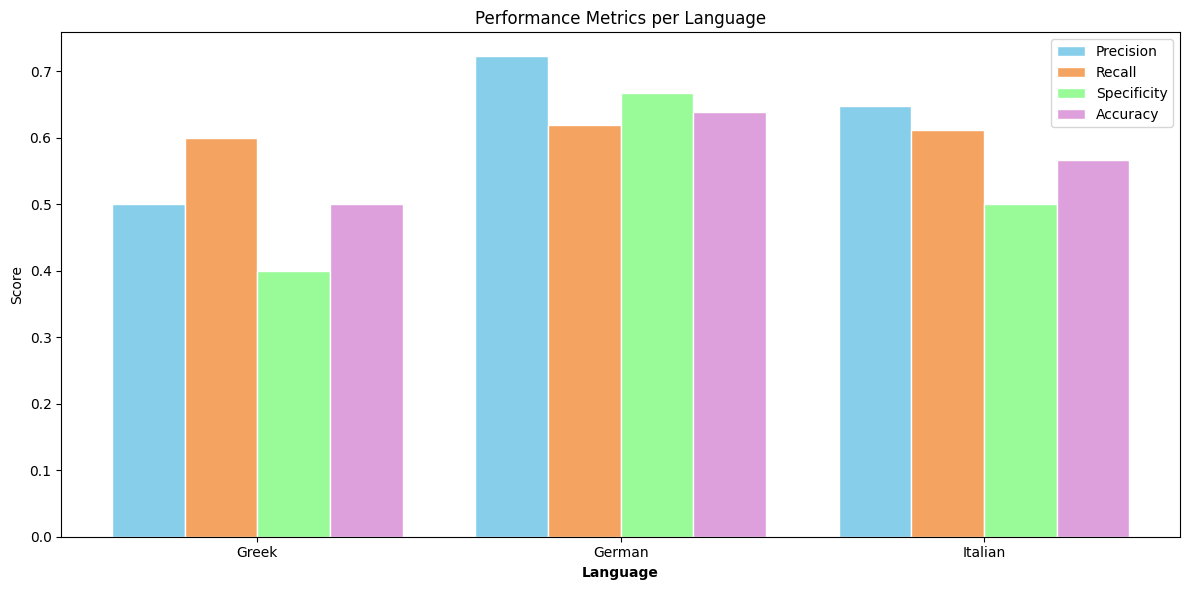

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Evaluate performance per language
print("\nEvaluating performance per language...\n")
languages = df['Language'].unique()
performance_metrics = []

for language in languages:
    df_lang = df[df['Language'] == language]
    true_labels = df_lang['actual_irony']
    pred_labels = df_lang['predicted_irony']

    # Check if both classes are present in the subset
    if len(true_labels.unique()) < 2:
        print(f"Language '{language}' does not have both classes. Skipping metrics calculation for this language.")
        continue

    # Calculate metrics
    report_lang = classification_report(true_labels, pred_labels, output_dict=True)
    conf_matrix_lang = confusion_matrix(true_labels, pred_labels)
    tn_l, fp_l, fn_l, tp_l = conf_matrix_lang.ravel()

    precision_l = report_lang['1']['precision']
    recall_l = report_lang['1']['recall']
    specificity_l = tn_l / (tn_l + fp_l)
    accuracy_l = report_lang['accuracy']

    # Append metrics to the list
    performance_metrics.append({
        'Language': language,
        'Precision': precision_l,
        'Recall': recall_l,
        'Specificity': specificity_l,
        'Accuracy': accuracy_l
    })

    # Print metrics for the language
    print(f"Performance Metrics for {language}:")
    print(f"Precision: {precision_l:.4f}")
    print(f"Recall (Sensitivity): {recall_l:.4f}")
    print(f"Specificity: {specificity_l:.4f}")
    print(f"Accuracy: {accuracy_l:.4f}\n")

# Create a DataFrame for performance metrics
performance_df = pd.DataFrame(performance_metrics)

# Identify the language with the worst performance based on accuracy
worst_language = performance_df.loc[performance_df['Accuracy'].idxmin()]
print(f"Language with the worst performance: {worst_language['Language']}")
print(f"Metrics for {worst_language['Language']}:")
print(worst_language)

# Plotting metrics per language with different colors
metrics = ['Precision', 'Recall', 'Specificity', 'Accuracy']

# Set up bar width and positions
bar_width = 0.2
r1 = np.arange(len(performance_df['Language']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]
r4 = [x + bar_width*3 for x in r1]

plt.figure(figsize=(12,6))

# Plot each metric
plt.bar(r1, performance_df['Precision'], color='skyblue', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, performance_df['Recall'], color='sandybrown', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, performance_df['Specificity'], color='palegreen', width=bar_width, edgecolor='white', label='Specificity')
plt.bar(r4, performance_df['Accuracy'], color='plum', width=bar_width, edgecolor='white', label='Accuracy')

# Add xticks on the middle of the group bars
plt.xlabel('Language', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(performance_df['Language']))], performance_df['Language'])

# Add y-axis label and title
plt.ylabel('Score')
plt.title('Performance Metrics per Language')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
